# H&M Personalized Fashion Recommendations
In this notebook, I will do an EDA on the H&M dataset and develop a basic Recommendation system.

Competition [Link](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations)

Description of the Task:

For this task i have 3 CSV file:
1.   Articles
2.   Customers
3.   Transactions


In [104]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import matplotlib.style as style

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Exploration

In [106]:
articles = pd.read_csv('/content/drive/MyDrive/Rec sys/Final/articles.csv' , dtype={'article_id': str})
customers = pd.read_csv('/content/drive/MyDrive/Rec sys/Final/customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Rec sys/Final/transactions_train.csv',dtype={'article_id': str})

### Customers Dataset

Since the Transaction file is Huge. I'll take a fraction of the customer file and do inner join later on transaction file


In [107]:
customers = customers.sample(frac=0.50)

In [108]:
print(f"{len(customers)} Customers were found in the CSV file.")

685990 Customers were found in the CSV file.


In [109]:
#Checking NaN Values
customers.isna().sum()

customer_id                    0
FN                        447548
Active                    453840
club_member_status          3018
fashion_news_frequency      8123
age                         7995
postal_code                    0
dtype: int64

In [110]:
#Check the Dtype of each column
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685990 entries, 18429 to 1194468
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   customer_id             685990 non-null  object 
 1   FN                      238442 non-null  float64
 2   Active                  232150 non-null  float64
 3   club_member_status      682972 non-null  object 
 4   fashion_news_frequency  677867 non-null  object 
 5   age                     677995 non-null  float64
 6   postal_code             685990 non-null  object 
dtypes: float64(3), object(4)
memory usage: 41.9+ MB


In the following table, we can see that the data are unbalanced since in the column of age there are outliers because 75% of the data have an age of 49, however the remaining 25% have an age greater than 49.


In [111]:
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
FN,238442.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Active,232150.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
age,677995.0,36.380403,14.305997,16.0,24.0,32.0,49.0,99.0


Here is a scatterplot that illustrates the following link between age and count

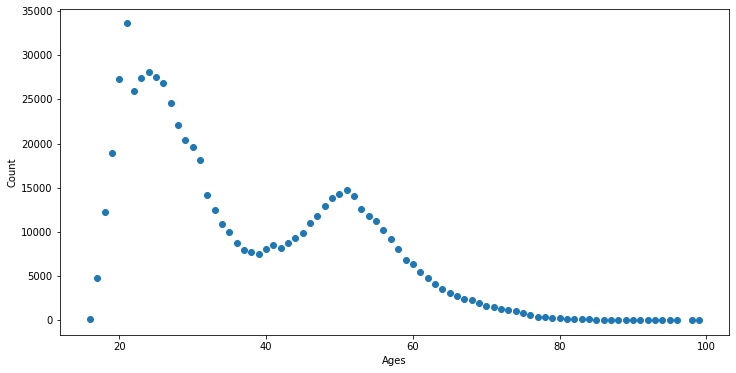

In [112]:
fig, ax = plt.subplots(figsize=(12,6))
y=customers['age'].value_counts()
ax.scatter(y.index, y.values)

ax.set_xlabel('Ages')

ax.set_ylabel('Count')

plt.show()

To overcome this problem will identify the outliers with Interquartile Range (IQR) which will calculated as the difference between the 75th (Q3) and 25th (Q1) percentiles 

In [113]:
Q1 = customers['age'].quantile(0.25)
Q3 = customers['age'].quantile(0.75)
IQR = Q3 - Q1
customers = customers[~((customers['age'] < (Q1 - 1.5 * IQR)) | (customers['age'] > (Q3 + 1.5 * IQR)))]

This is the scatterplot after we successfully eliminated the outliers, as can be seen here

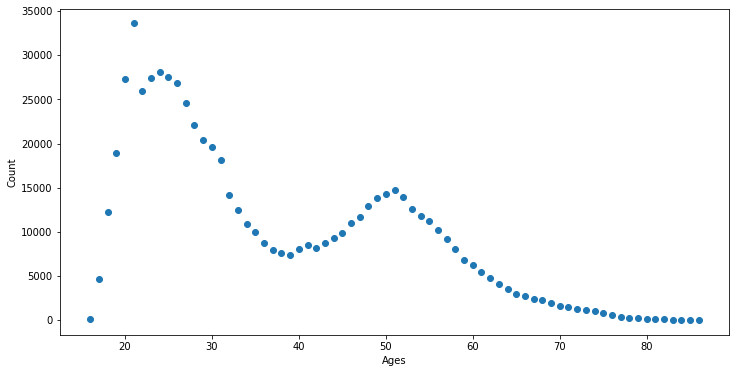

In [114]:
fig, ax = plt.subplots(figsize=(12,6))
y=customers['age'].value_counts()
ax.scatter(y.index, y.values)

ax.set_xlabel('Ages')

ax.set_ylabel('Count')

plt.show()

There are five columns containing NaN values.


For the first two columns, **FN** and **Active**, no modifications will be made because NaN values indicate whether a customer is subscribed or not.


For the **Club member status** and **Fashion news frequency**, the NaN values will be replaced by the highest frequency value, which are **Active** and **None**, respectively.

In [115]:
Nanvalues = ['FN','Active','club_member_status','fashion_news_frequency']
for column in Nanvalues:
  print(column)
  values = customers[column].value_counts()
  print(values)
  print(100*"_")

FN
1.0    238407
Name: FN, dtype: int64
____________________________________________________________________________________________________
Active
1.0    232118
Name: Active, dtype: int64
____________________________________________________________________________________________________
club_member_status
ACTIVE        636130
PRE-CREATE     46492
LEFT CLUB        235
Name: club_member_status, dtype: int64
____________________________________________________________________________________________________
fashion_news_frequency
NONE         438689
Regularly    238621
Monthly         443
None              2
Name: fashion_news_frequency, dtype: int64
____________________________________________________________________________________________________


In [116]:
customers['age'].fillna(value = customers['age'].mean(), inplace = True)
customers['fashion_news_frequency'].fillna(value = "NONE", inplace = True)
customers['club_member_status'].fillna(value = "ACTIVE", inplace = True)
customers['fashion_news_frequency'].replace({"None": "Regularly"},inplace=True)

As shown above, the Datatype of the column **Age** is float; thus, I will convert it to an integer so that I may run more computations on it.

In [117]:
customers['age'] = customers['age'].astype(int)

In [118]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685875 entries, 18429 to 1194468
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   customer_id             685875 non-null  object 
 1   FN                      238407 non-null  float64
 2   Active                  232118 non-null  float64
 3   club_member_status      685875 non-null  object 
 4   fashion_news_frequency  685875 non-null  object 
 5   age                     685875 non-null  int64  
 6   postal_code             685875 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 41.9+ MB


Let us examine the age distribution of the customers.

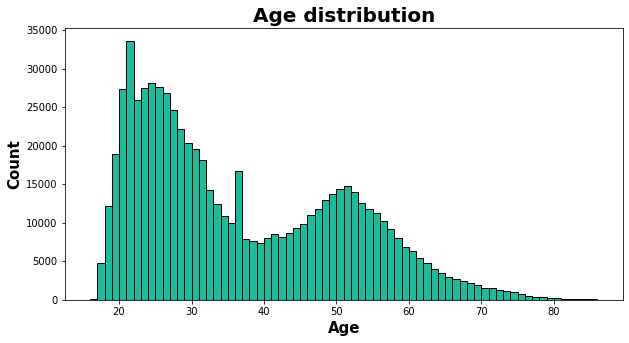

In [119]:
plt.figure(figsize=(10,5))
plt.title("Age distribution", fontweight="bold", size=20)
plt.hist(customers["age"], bins=70, edgecolor="black", color="#1ABC9C")
plt.xlabel("Age",fontweight="bold", size=15)
plt.ylabel("Count",fontweight="bold", size=15)
plt.show()

Since the age distribution graph is unattractive due to the 70 bins, I've decided to add age groupings to make it more comprehensible.

In [120]:
bins = [-np.inf, 20, 30, 40, 50, 60, 70, 80, np.inf]
age_labels = ["-20",'20-30','30-40','40-50','50-60','60-70', '70-80','+80']
customers['range'] = pd.cut(customers.age,bins = bins,labels = age_labels,right = False)

### Transactions Dataset

Now it will be ready to inner join the two datasets on the customer id column, which will allow us to compute revenue and determine what each client has purchased.

In [121]:
transactions_m = pd.merge(customers,transactions,on='customer_id')

Certainly Because a single consumer might have several transactions, we will not have the same length 


In [122]:
print(f"{len(transactions_m)} transactions were found in the CSV file.")

15904470 transactions were found in the CSV file.


In [123]:
transactions_m.customer_id[0]

'03766f105e533bb6efe3d4800b4162dff2388043ff652328388bbc6d44f66145'

In [124]:
count =0
for id in transactions_m.customer_id:
  if id == "00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657":
    count+=1
print(f"For Example: First customer in the data has a {count} transactions")

For Example: First customer in the data has a 21 transactions


In [125]:
#Checking for NaN Values
transactions_m.isna().sum()

customer_id                     0
FN                        9119059
Active                    9221913
club_member_status              0
fashion_news_frequency          0
age                             0
postal_code                     0
range                           0
t_dat                           0
article_id                      0
price                           0
sales_channel_id                0
dtype: int64

## Data Visualizations

Creating a functions to visualize the columns easily

In [126]:
def set_custom_palette(series, max_color = 'green', other_color = 'lightgrey'):
  '''
  This function will take a Counts column as input 
  and will return the highest values Colored 
  '''
  max_val = series.max()
  pal = []
  
  for item in series:
      if item == max_val:
          pal.append(max_color)
      else:
          pal.append(other_color)
  return pal

In [127]:
def high_per_barplot(column=None,title=None,xlabel=None,ylabel=None,ax=None):
  '''
  This function will generate a barplot with percentages atop each bar, and the bar with most values will be highlighted
  '''
  counts = column.value_counts().reset_index()[:10]

  percentage = []
  for x in range(counts.shape[0]):
      pct = (counts.iloc[:,1][x] / counts.iloc[:,1].sum()) * 100
      percentage.append(round(pct,2))
  counts['Percentage'] = percentage
  
  counts = counts.sort_values('index')
  

  style.use('seaborn-poster')
  style.use('ggplot')

  g = sns.barplot(x=counts.iloc[:,0],  y=counts.iloc[:,1],ax=ax,palette=set_custom_palette(counts.iloc[:,1])) 

  i = 0

  for p in g.patches:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2,
              y+height*1.01,
              str(counts['Percentage'].iloc[i])+'%',
              ha='center',
              weight='bold')
      i+=1

  plt.title(title, fontweight="bold",fontsize=20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel(xlabel, fontweight="bold", fontsize=15)
  plt.ylabel(ylabel, fontweight="bold", fontsize=15)

  plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)


  plt.show()

In [128]:
def per_barplot(column=None,title=None,xlabel=None,ylabel=None,color=None,palette=None,ax=None):
  '''
  This function will generate a barplot with percentages atop each bar
  '''
  counts = column.value_counts().reset_index()[:10]

  percentage = []
  for x in range(counts.shape[0]):
      pct = (counts.iloc[:,1][x] / counts.iloc[:,1].sum()) * 100
      percentage.append(round(pct,2))
  counts['Percentage'] = percentage
  
  counts = counts.sort_values('index',ascending=True)  

  style.use('seaborn-poster')
  style.use('ggplot')

  g = sns.barplot(x=counts.iloc[:,0],  y=counts.iloc[:,1],ax=ax,color = color,palette=palette) 

  i = 0
  for p in g.patches:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2,
              y+height*1.01,
              str(counts['Percentage'].iloc[i])+'%',
              ha='center',
              weight='bold')
      i+=1

  plt.title(title, fontweight="bold",fontsize=20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel(xlabel, fontweight="bold", fontsize=15)
  plt.ylabel(ylabel, fontweight="bold", fontsize=15)

  plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)


  plt.show()

In [129]:
def h_per_barplot(column=None,title=None,xlabel=None,ylabel=None,color=None,palette=None,ax=None):
  '''
  This function will generate a horizental barplot with percentages atop each bar
  '''
  counts = column.value_counts().reset_index()[:10]

  percentage = []
  for x in range(counts.shape[0]):
      pct = (counts.iloc[:,1][x] / counts.iloc[:,1].sum()) * 100
      percentage.append(round(pct,2))
  counts['Percentage'] = percentage
  
  counts = counts.sort_index(ascending=True)


  style.use('seaborn-poster')
  style.use('ggplot')

  g = sns.barplot(y=counts.iloc[:,0],  x=counts.iloc[:,1],ax=ax,orient = 'h',color=color,palette=palette) 

  i = 0
  for p in g.patches:
      width = p.get_width()
      g.text(width+1,
              p.get_y() + p.get_height() / 2,
              str(counts['Percentage'].iloc[i])+'%',
              ha='left',
             va = 'center',
              weight='bold')
      i+=1

  plt.title(title, fontweight="bold",fontsize=20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel(xlabel, fontweight="bold", fontsize=15)
  plt.ylabel(ylabel, fontweight="bold", fontsize=15)

  plt.grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)


  plt.show()

In [130]:
def high_h_per_barplot(column=None,title=None,xlabel=None,ylabel=None,ax=None,color=None):
  '''
  This function will generate a horizental barplot with percentages atop each bar, and the bar with most values will be highlighted
  '''
  counts = column.value_counts().reset_index()[:10]

  percentage = []
  for x in range(counts.shape[0]):
      pct = (counts.iloc[:,1][x] / counts.iloc[:,1].sum()) * 100
      percentage.append(round(pct,2))
  counts['Percentage'] = percentage
  
  counts = counts.sort_index(ascending=True)
  

  style.use('seaborn-poster')
  style.use('ggplot')

  g = sns.barplot(y=counts.iloc[:,0],  x=counts.iloc[:,1],ax=ax,orient = 'h',color = color,palette=set_custom_palette(counts.iloc[:,1])) 

  i = 0
  for p in g.patches:
      width = p.get_width()
      g.text(width+1,
              p.get_y() + p.get_height() / 2,
              str(counts['Percentage'].iloc[i])+'%',
              ha='left',
             va = 'center',
              weight='bold')
      i+=1

  plt.title(title, fontweight="bold",fontsize=20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel(xlabel, fontweight="bold", fontsize=15)
  plt.ylabel(ylabel, fontweight="bold", fontsize=15)

  plt.grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)


  plt.show()

In [131]:
def pie_chart(column):
  '''
  This function will generate pie chart with percentages inside
  '''
  x=column.value_counts().reset_index()
  fig = px.pie(x,values=x.iloc[:,1],names=x.iloc[:,0])
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

### Customers Analysis

#### Which age group buys the most?

First, we will evaluate the age group we've formed to determine which age group is represented the most.

According to the graph, those between the ages of **20-30** are the most likely to purchase H&M items.

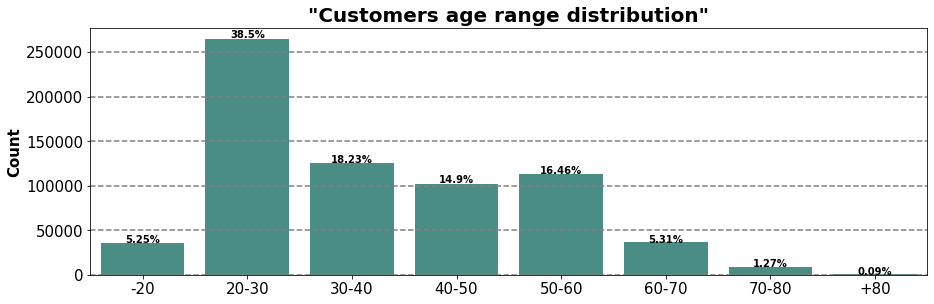

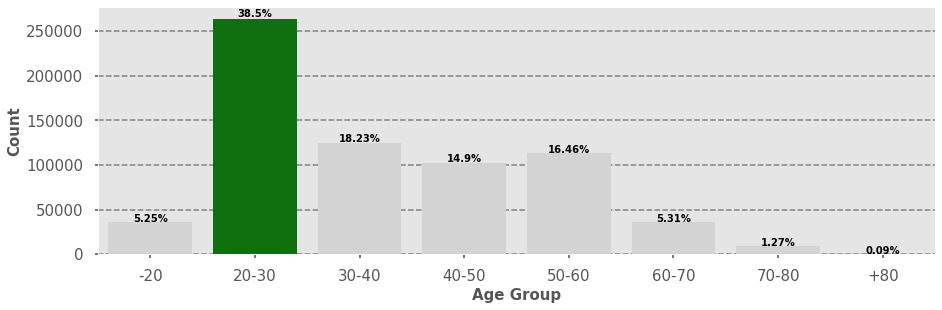

In [132]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
per_barplot(column=customers['range'],title='"Customers age range distribution"',ylabel='Count',color='#3e988e')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_per_barplot(column=customers['range'],xlabel='Age Group',ylabel='Count')

#### Status of club members

Nearly 94% of customers are Active club members

In [133]:
pie_chart(customers["club_member_status"])

#### Fashion News

65.1% of clients do not monitor fashion news, whereas 34.8% do so frequently and 0.1% do so monthly.

In [134]:
pie_chart(customers["fashion_news_frequency"])

### Article Analysis

#### Which categories received the most hits?

We tried to figure out the top 10 categories that H&M sells, and according to the graph below, 40% of products fall under the Garment upper body category followed by 18.8% of Garment lower body.

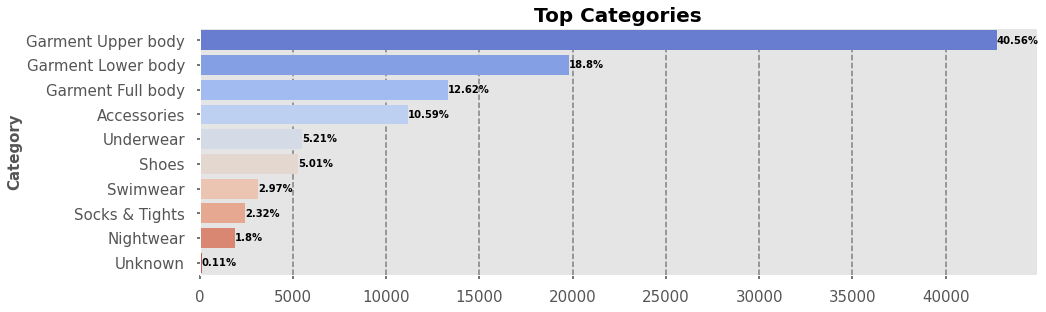

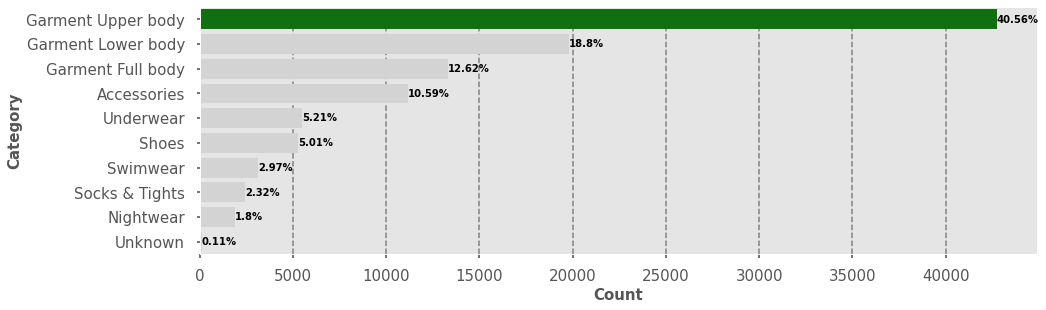

In [135]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['product_group_name'],title='Top Categories',ylabel='Category',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['product_group_name'],xlabel='Count',ylabel='Category')


Since certain categories are produced more often than others, and then  it will be warehoused.


To further dissect the categories, we discovered that H&M earns a profit from Ladieswear, Babies, and Childrenswear, as indicated in the graph below.

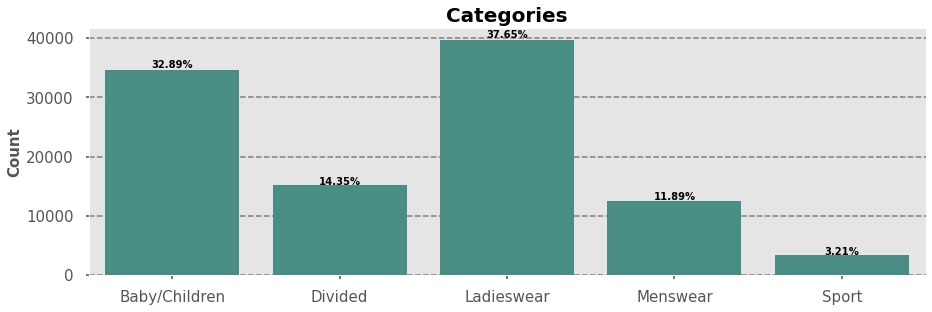

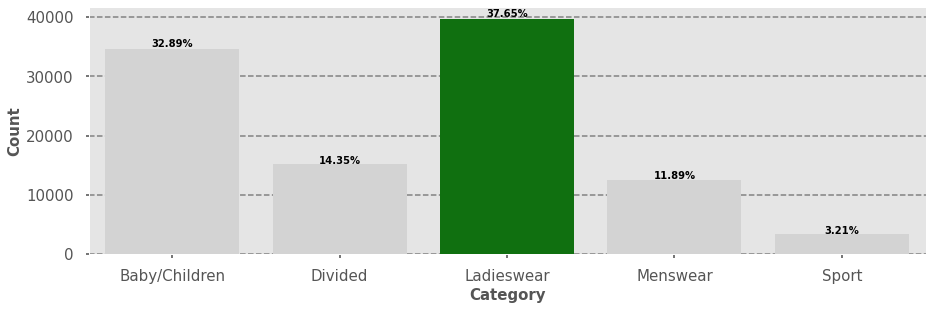

In [136]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
per_barplot(column=articles['index_group_name'],title='Categories',ylabel='Count',color='#3e988e')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_per_barplot(column=articles['index_group_name'],xlabel='Category',ylabel='Count')

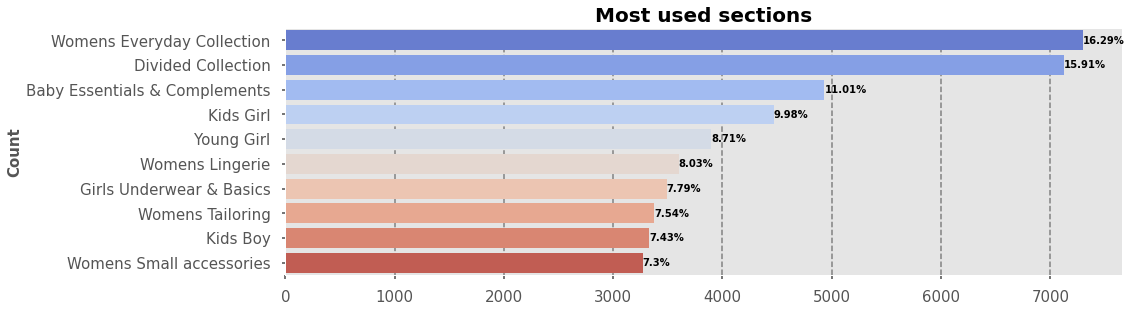

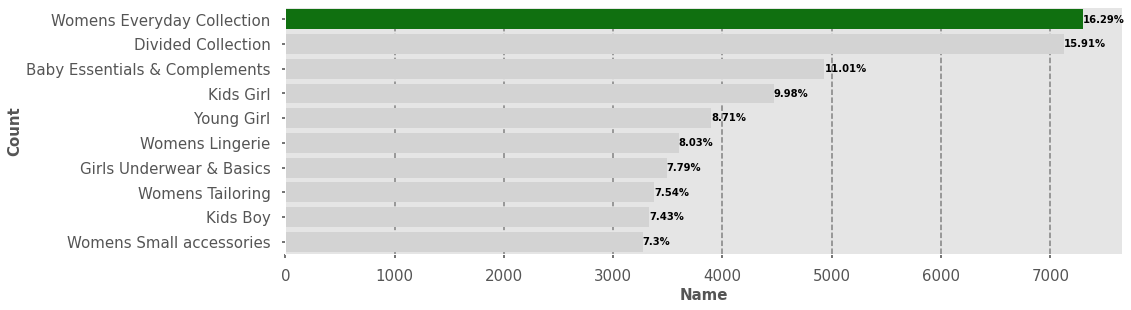

In [137]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['section_name'],title="Most used sections",ylabel='Count',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['section_name'],xlabel='Name',ylabel='Count')

#### What is the most frequent type of clothing in stock?

As indicated in the figures below, H&M's two most popular product types are Trousers and Dress, with respective market shares of 18.27% and 16.95%.

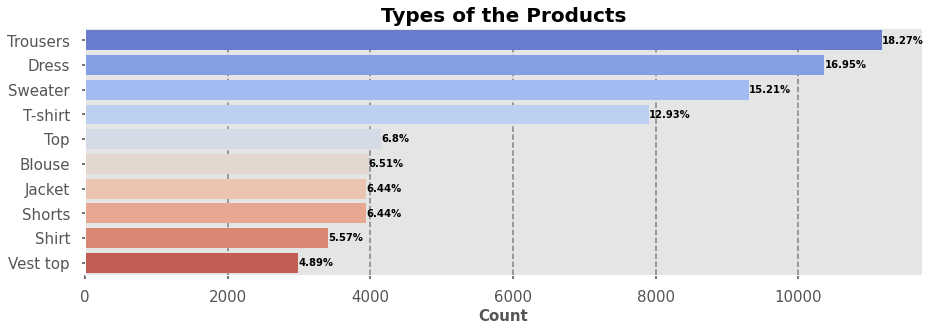

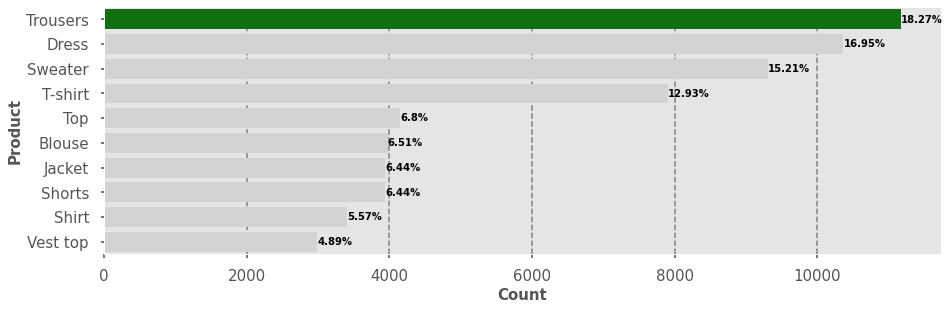

In [138]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['product_type_name'],title="Types of the Products",xlabel='Count',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['product_type_name'],ylabel='Product',xlabel='Count')

#### Which products are listed the most?

Top 10 products in the stock

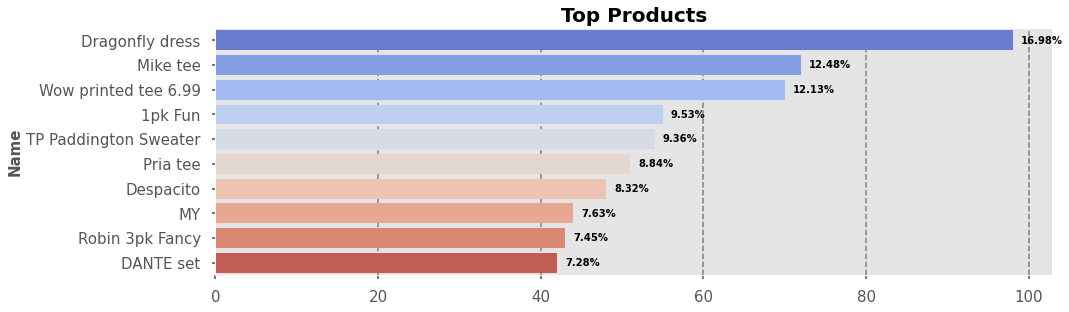

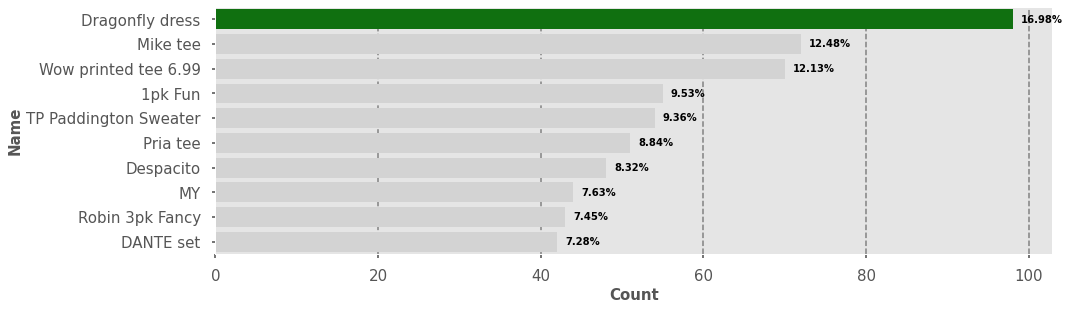

In [139]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['prod_name'],title="Top Products",ylabel='Name',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['prod_name'],xlabel='Count',ylabel='Name')

#### What are top products patterns? 

We are able to conclude that H&M seems to have more solid patterns than other designs.

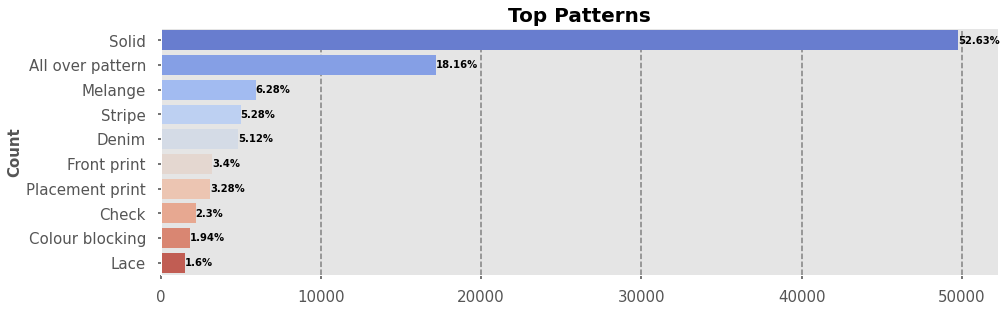

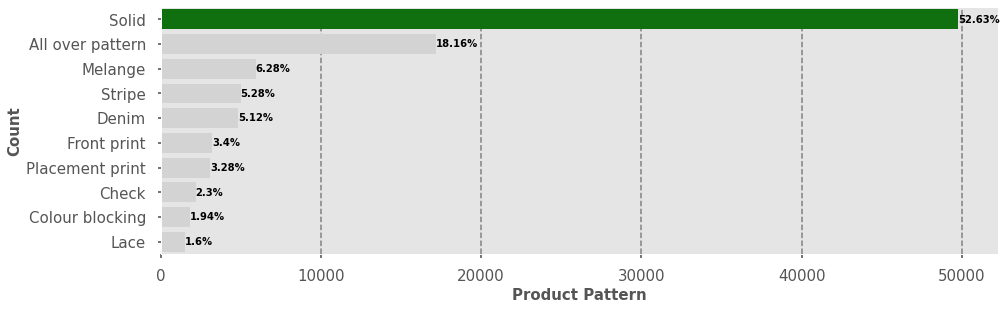

In [140]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['graphical_appearance_name'],title="Top Patterns",ylabel='Count',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['graphical_appearance_name'],xlabel='Product Pattern',ylabel='Count')

#### What are the most common colors found in stock?

As can be seen in the figure below, there are a variety of color variations. As a result, I attempted some approaches to collect all the fundamental colors in order to analyze the stock colors more clearly.

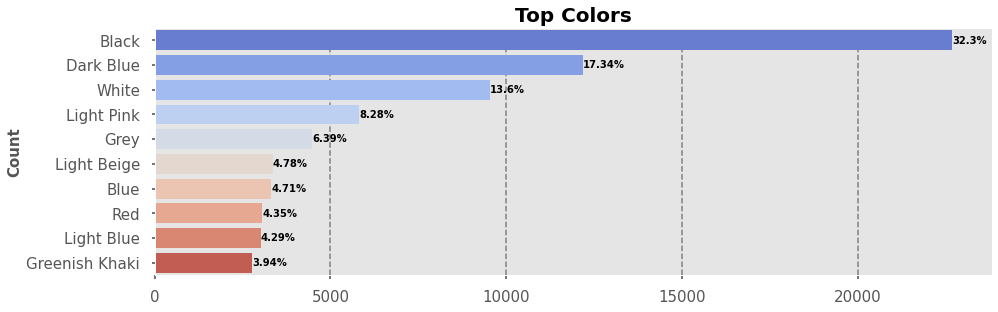

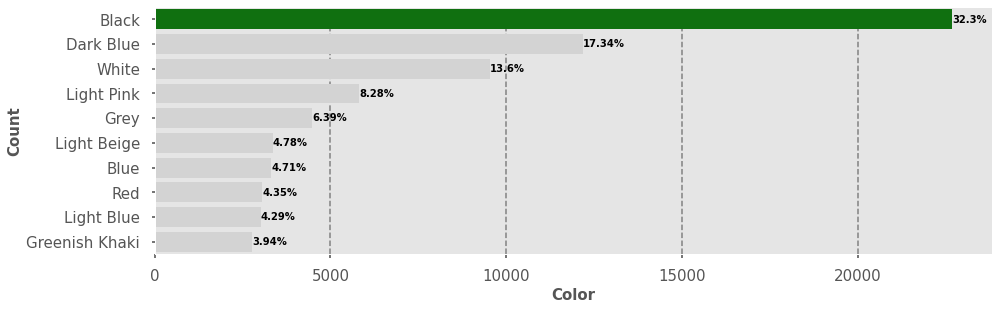

In [141]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['colour_group_name'],title="Top Colors",ylabel='Count',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['colour_group_name'],xlabel='Color',ylabel='Count')

Here, I'm identifying all the fundamental colors, adding them to a dictionary, then transforming the dictionary into a dataframe.

In [142]:
color_names = ['black','blue','white','pink','grey','green','Khaki green','yellow','red','beige']
found_colors = [color for i in articles['colour_group_name'] for color in color_names if color.lower() in i.lower()]
counts = dict()
for i in found_colors:
  counts[i] = counts.get(i, 0) + 1
Colors = pd.DataFrame(counts.items(),columns=['index','Counts'])

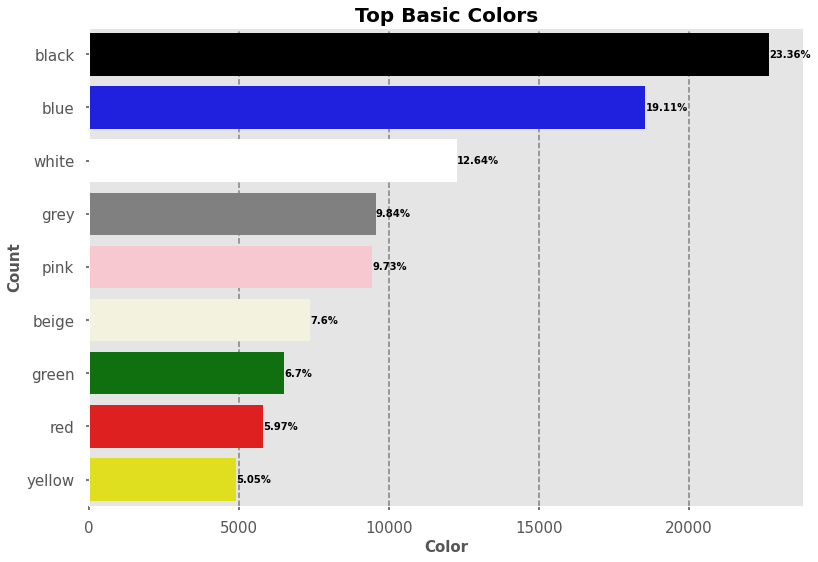

In [143]:
percentage = []
for x in range(Colors.shape[0]):
    pct = (Colors.iloc[:,1][x] / Colors.iloc[:,1].sum()) * 100
    percentage.append(round(pct,2))
Colors['Percentage'] = percentage

Colors = Colors.sort_values("Counts",ascending=False)


style.use('seaborn-poster')
style.use('ggplot')

g = sns.barplot(y=Colors.iloc[:,0],  x=Colors.iloc[:,1],orient = 'h',palette=['black','blue','white','grey','pink','beige','green','red','yellow']) 

i = 0


for p in g.patches:
    width = p.get_width()
    g.text(width+1,
            p.get_y() + p.get_height() / 2,
            str(Colors['Percentage'].iloc[i])+'%',
            ha='left',
            va = 'center',
            weight='bold')
    i+=1

plt.title('Top Basic Colors', fontweight="bold",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Color', fontweight="bold", fontsize=15)
plt.ylabel('Count', fontweight="bold", fontsize=15)

plt.grid(axis="x",color = 'grey', linestyle = '--', linewidth = 1.5)


plt.show()

#### Which departments has more products?

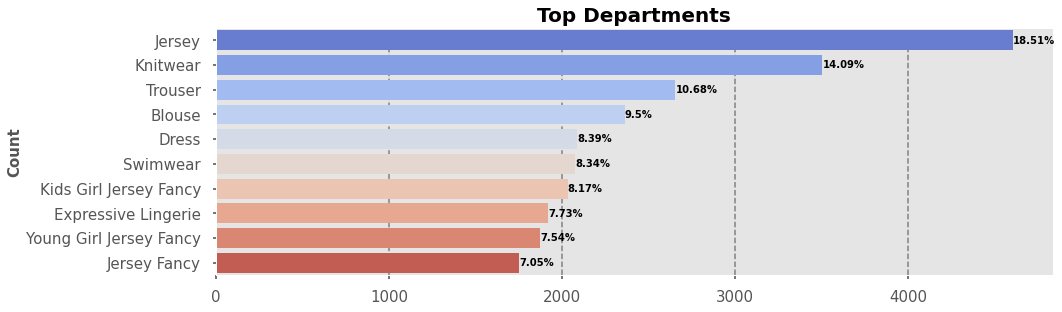

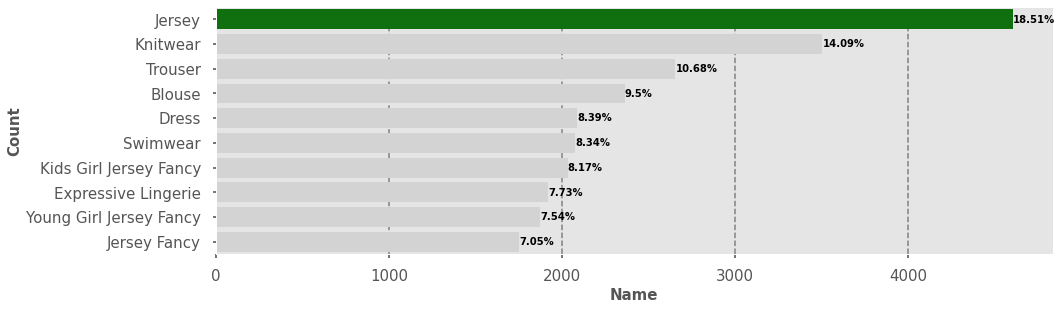

In [144]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
h_per_barplot(articles['department_name'],title="Top Departments",ylabel='Count',palette='coolwarm')
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 2)
high_h_per_barplot(articles['department_name'],xlabel='Name',ylabel='Count')

### Sales Analysis

#### Which age group generates the most money for the organization?
Here is the revenue created by age group, and we can see that the 20-30 age group generates the most money because they are responsable for the highest volumn of sales.

Age Group          | Revenue
-------------------|------------------
20-30              | 354464.338678
30-40              | 184025.067797 
50-60              | 151040.965898 
40-50              | 135460.247390 
60-70              | 36494.450661
-20                | 16295.417186
70-80              | 6328.135864 
+80                | 455.063492



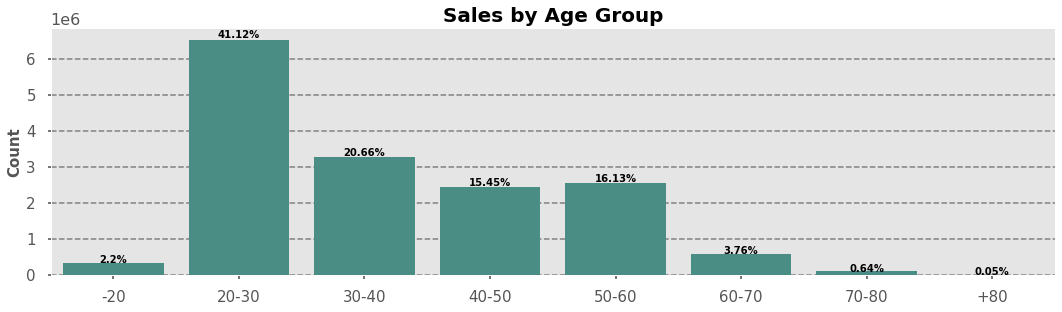

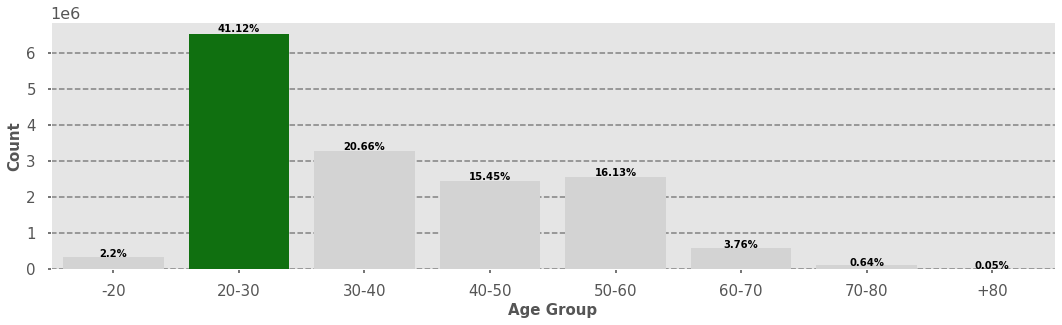

In [145]:
plt.figure(figsize=(18,10))
plt.subplot(2, 1, 1)
per_barplot(column=transactions_m['range'],title="Sales by Age Group",ylabel='Count',color='#3e988e')
plt.figure(figsize=(18,10))
plt.subplot(2, 1, 2)
high_per_barplot(column=transactions_m['range'],xlabel='Age Group',ylabel='Count')


In [146]:
transactions_m['TotalSales'] = transactions_m['price'].groupby(transactions_m['range']).transform('sum')

In [147]:
transactions_m.TotalSales.value_counts()

177656.902424    6539755
92097.136932     3285176
75479.481644     2566028
67728.369458     2457046
18128.288508      597949
8241.799881       349527
3182.363898       101779
238.044203          7210
Name: TotalSales, dtype: int64

#### Fashion News

Customers who are followed the fashion news are responable for almost 43% of all sales. Nevertheless, Regular Customers who are not subscribed represents 57% of Sales.

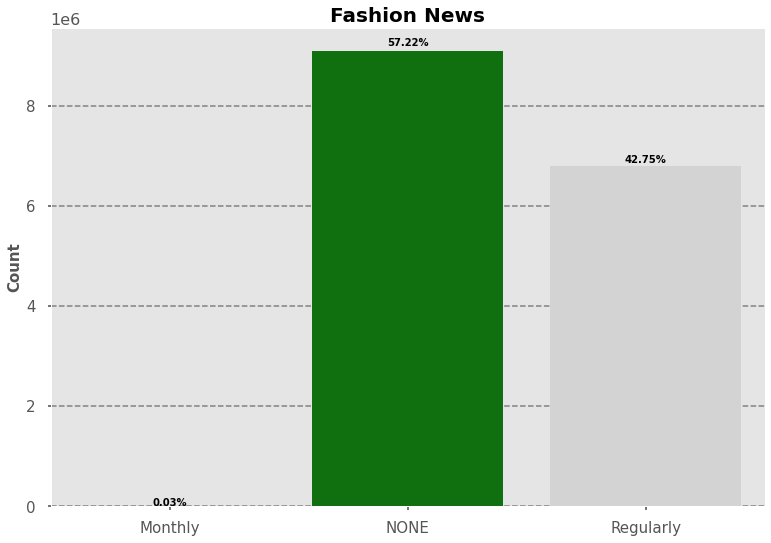

In [148]:
high_per_barplot(column=transactions_m['fashion_news_frequency'],title="Fashion News",ylabel='Count')

#### Are club members more likely to purchase than others?

Customers who are subscibe to club member are responable for nearly 98% of Sales

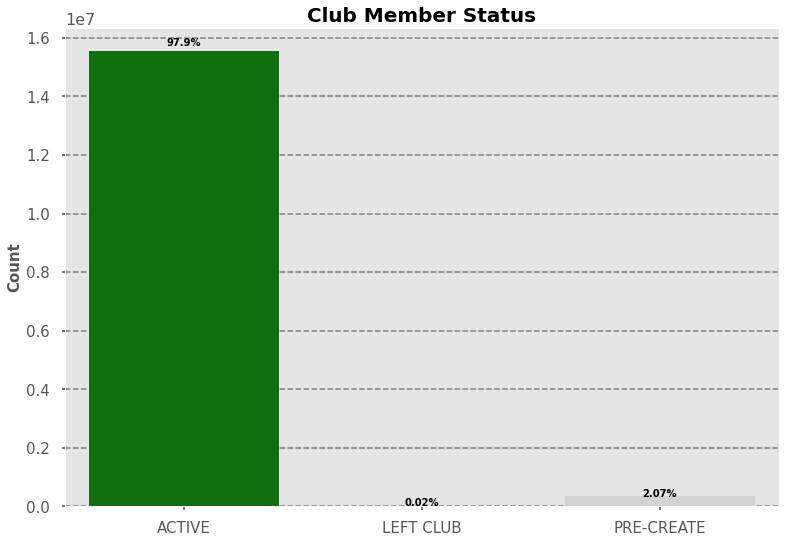

In [149]:
high_per_barplot(column=transactions_m['club_member_status'],title="Club Member Status",ylabel='Count')

#### Which channel generates more revenue?

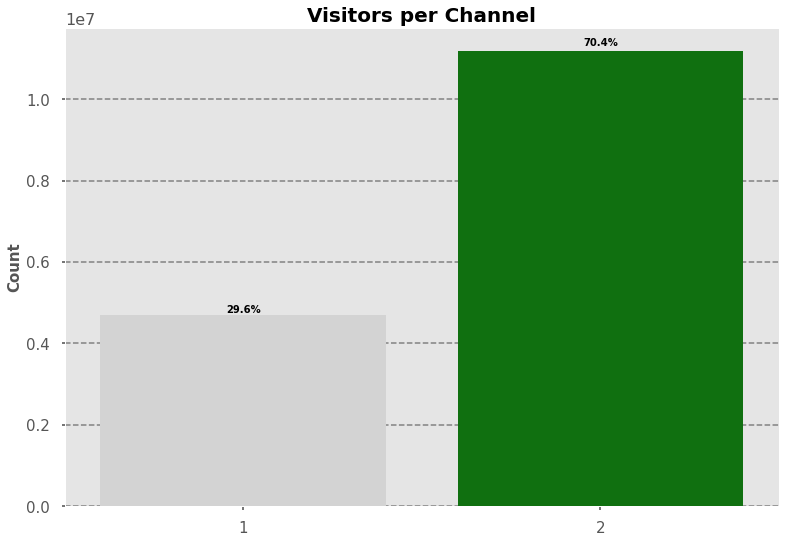

In [150]:
#1 offline and 2 is online
high_per_barplot(column=transactions_m['sales_channel_id'],title="Visitors per Channel",ylabel='Count')

## Recommendation system

I don't know how to go with constructing a recommendation system. I've tried BVA and SVD, but none worked for me.
Here, I attempted to provide a dummy rating and follow the same steps in the notebook but didn't work for me too.

In [151]:
import cornac
from surprise import SVD
from surprise import Dataset, Reader
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.evaluation.python_evaluation import rmse, mae, map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [152]:
train = transactions.sample(frac=0.0001)
len(train)

3179

In [153]:
test = transactions.sample(frac=0.0001)
len(test)

3179

In [154]:
test['rating']= np.random.randint(0,6,size=(len(test),1))
train['rating']= np.random.randint(0,6,size=(len(test),1))

In [155]:
train = train.drop(['t_dat','sales_channel_id','price'],axis=1)
test = test.drop(['t_dat','sales_channel_id','price'],axis=1)

In [156]:
test

,customer_id,article_id,rating
7729300,8fb30c5a92d34336a83af999e4d342ba6f33efcb31d00b...,0189626001,0
29501515,371a984cebbea6256be899ca18a6c618d8d94576bab949...,0869473001,1
13413074,7f8a44dc840fd19d6fab22ad7d569ef11d19d2ab945006...,0757482002,2
3330580,45a00c147ec5769b89d56d4893d572ee0f4c3e444e9963...,0490113004,1
9558522,80755a5e375b084b7a85716e25706da6c6888d89b4a9ea...,0588423003,5
...,...,...,...
13265626,ef67c2dfc0f8583001abb92aa63e89b5ae76f7843b9fa9...,0372860002,2
4901799,788ee473e9d0e8aed9895fe7f2911b253d11293d475d59...,0743014004,3
27839350,70a29c64cea36f46e9fd100df3b3e029e63c5dbcfb9ea2...,0816592007,4
9541788,3b0b0ea0f3a09f2132a20119124420ee27bd9572ce5b0e...,0704720001,4


In [157]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=42)
train_set

/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning:

1 duplicated observations are removed!



In [158]:
bivae = cornac.models.BiVAECF(k=25,
                              encoder_structure=[100, 100, 100],
                              act_fn="tanh",
                              likelihood="pois",
                              n_epochs=100,
                              batch_size=128,
                              learning_rate=0.001,
                              seed=42,
                              use_gpu=True,
                              verbose=True)

In [159]:
bivae.fit(train_set)

  0%|          | 0/100 [00:00<?, ?it/s]

In [160]:
bivae_all_predictions = predict_ranking(bivae, train, usercol='customer_id', itemcol='article_id', remove_seen=True)

In [161]:
args = {'col_user': 'customer_id', 'col_item': 'article_id', 'col_rating': 'rating'}

k = 50
mapk = map_at_k(test, bivae_all_predictions, k=k, **args)
pk = precision_at_k(test, bivae_all_predictions, k=k, **args)

print(f'Precision at {k} : {pk} - Mean AP@k={k} : {mapk}')

Precision at 50 : 0.0 - Mean AP@k=50 : 0.0


In [162]:
train_set = Dataset.load_from_df(train, reader=Reader(rating_scale=(1,5))).build_full_trainset()
train_set

In [163]:
svd = SVD(random_state=42, n_factors=200, n_epochs=30, verbose=True)
svd.fit(train_set)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [164]:
svd_predictions = predict(svd, test, usercol='customer_id', itemcol='article_id')
svd_predictions.head()

,customer_id,article_id,prediction
0,8fb30c5a92d34336a83af999e4d342ba6f33efcb31d00b...,0189626001,2.469645
1,371a984cebbea6256be899ca18a6c618d8d94576bab949...,0869473001,2.739021
2,7f8a44dc840fd19d6fab22ad7d569ef11d19d2ab945006...,0757482002,2.469645
3,45a00c147ec5769b89d56d4893d572ee0f4c3e444e9963...,0490113004,2.469645
4,80755a5e375b084b7a85716e25706da6c6888d89b4a9ea...,0588423003,2.469645


In [165]:
svd_all_predictions = compute_ranking_predictions(svd, train[['customer_id', 'article_id', 'rating']], usercol='customer_id', itemcol='article_id', remove_seen=True)

In [166]:
args = {'col_user': 'customer_id', 'col_item': 'article_id', 'col_rating': 'rating'}

k = 50
rmse_ = rmse(test, svd_predictions, **args)
mapk = map_at_k(test, svd_all_predictions, k=k, **args)
pk = precision_at_k(test, svd_all_predictions, k=k, **args)

print(f'Precision at {k} : {pk} - Mean AP@k={k} : {mapk}')
print('RMSE : ', rmse_)

Precision at 50 : 0.0 - Mean AP@k=50 : 0.0
RMSE :  1.7272688316167342
